In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in note"book, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is an iterated attempt to calculate the KDE used as input to PvFinder. We are reading in  a poca KDE (KDE_A to start) rather than the original KDEs. 

The starting point here is a trained version of TracksToKDE_DD (fully connected layers only) to which we add some convolutional layers and a final fully connected layer (because only CNN stalls).

collectdata_kde_C.py uses poca_z, poca_x, poca_y, major_axis_x, major_axis_y, and major_axis_z as the six track parameters (for the moment)


Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Sun Jan 17 00:36:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 31%   40C    P0    33W / 250W |      0MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   34C    P0    28W / 250W |      0MiB / 16280MiB |      4%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

This notebook is first attempt to read in track information and use it to predict the KDE used as input to PvFinder.


## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

##from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 300

# Name is the output file name


##  201027 -- about to go to bed, so try 2500 epochs with lr = 1e55
##  previous iteration had l4 = 3e-5 and cost dropped almost linearly
##  for 100 epochs -- final training costs ~ 2.02, validation cost ~ 2.01

## for iter 4, try 10 epochs with lr = 3e-6
## usually have a big jump down at epoch 0; want to try a
## small number of epochs per iteration and see what happens (iter4: 10 epochs gave
## traiing cost dropping from 1.54 to 1.50 immediately, then dropping very slowly)
folder = '16Jan2021_TracksToKDE_DDplusplus_loss_Ba_iter1_floatAll_300epochs_1em4_4xwill'
name   = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
##batch_size = 32 ## was 16 ---> on Titan V 5791MiB / 12066MiB; 32 ---> 10481MiB / 12066MiB [when freezing early layers]
batch_size = 24 
# How fast to learn
learning_rate = 1e-4

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
##from model.collectdata_kde_B import collect_t2kde_data
## collectdata_kde_C should use the new poca KDE rather than the original kernel KDE
from model.collectdata_kde_Ellipsoids import collect_t2kde_data


# From model/loss.py
### kde_loss_Ba is just a chisq loss, normalized
from model.kde_loss_Ba import Loss


##  It takes 9 input features (pocca centers + (A,B,C,D,E,F) . 
from model.models_kde import TracksToKDE_DDplusplus as Model


from model.training_kde import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(0)
##device = "cpu"

1 available GPUs (initially using device 0):
  0 TITAN V


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [9]:
##print("Let's use", torch.cuda.device_count(), "GPUs!")
##if torch.cuda.device_count() > 1:
##    model = torch.nn.DataParallel(model)

In [10]:
## a comment on the web at https://pytorch.org/docs/stable/optim.html says
"""
If you need to move a model to GPU via .cuda(), please do so before constructing optimizers for it. 
Parameters of a model after .cuda() will be different objects with those before the call.

In general, you should make sure that optimized parameters live in consistent locations when 
optimizers are constructed and used.
"""
## so move this here (although we are using model.to(device) not explicitly using .cuda()

nOut1 = 50
nOut2 = 50
nOut3 = 50
nOut4 = 50
nOut5 = 50
nOut6 = 50
nOut7 = 50
nOut8 = 50
nOut9 = 50
nOut10 = 50
nOut11 = 50
latentChannels = 8
model = Model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa

## for iter0 we want the weights from the first 11 fully connected layers from DirtyDozen to be re-used without
## floating values (or those of their biases)

## for Iter1 let all the weights float
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
##  loss = Loss(epsilon=1e-5,coefficient=2.5)
##loss = Loss(epsilon=3e-5, debug=False)
loss = Loss(epsilon=3e-5)

ct, child =  0    Linear(in_features=9, out_features=50, bias=True)
ct, child =  1    Linear(in_features=50, out_features=50, bias=True)
ct, child =  2    Linear(in_features=50, out_features=50, bias=True)
ct, child =  3    Linear(in_features=50, out_features=50, bias=True)
ct, child =  4    Linear(in_features=50, out_features=50, bias=True)
ct, child =  5    Linear(in_features=50, out_features=50, bias=True)
ct, child =  6    Linear(in_features=50, out_features=50, bias=True)
ct, child =  7    Linear(in_features=50, out_features=50, bias=True)
ct, child =  8    Linear(in_features=50, out_features=50, bias=True)
ct, child =  9    Linear(in_features=50, out_features=50, bias=True)
ct, child =  10    Linear(in_features=50, out_features=50, bias=True)
ct, child =  11    Linear(in_features=50, out_features=32000, bias=True)
ct, child =  12    Conv1d(8, 25, kernel_size=(51,), stride=(1,), padding=(25,))
ct, child =  13    Conv1d(25, 15, kernel_size=(25,), stride=(1,), padding=(12,))
ct, chi

Let's move the model's weight matricies to the GPU:

In [11]:
model = model.to(device)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
##optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
##    print("value = ", v)
 
updated_dict = model_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]
updated_dict["layer6.bias"] = 0.005*model_dict["layer6.bias"]
updated_dict["layer7.bias"] = 0.005*model_dict["layer7.bias"]
updated_dict["layer8.bias"] = 0.005*model_dict["layer8.bias"]
updated_dict["layer9.bias"] = 0.005*model_dict["layer9.bias"]
updated_dict["layer10.bias"] = 0.005*model_dict["layer10.bias"]
updated_dict["layer11.bias"] = 0.005*model_dict["layer11.bias"]

model.load_state_dict(updated_dict,strict=False)

model_dict = model.state_dict()
##print("updated model_dict = ",model_dict)

## print(" \n","  for pretrained_dict")
## index = 0
##for k,v in pretrained_dict.items():
##    print("index, k =  ",index,"  ",k)
##    index = index+1
## mds  

##pretrained_dict = torch.load('ML/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50_final.pyt')
##print("model_dict instantiated")
# 1. filter out unnecessary keys
##pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
##print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
##model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

##model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)

## finished at training cost = 1.46, validation cost = 1.50
d_folder = '16Jan2021_TracksToKDE_DDplusplus_loss_Ba_iter0_floatAll_5epochs_1em4_4xwill'
d_name = d_folder
suffix = 'final'
dict_name = 'ML/' + d_folder + '/' + d_name + '_'+ suffix + '.pyt'
print('dict_name = ',dict_name)
pretrained_dict = torch.load(dict_name)

print(" ")
print("  for pretrained_dict")
index = 0
for k,v in pretrained_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
 

##print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=False)



output =  ML/16Jan2021_TracksToKDE_DDplusplus_loss_Ba_iter1_floatAll_300epochs_1em4_4xwill
for model_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6.weight
index, k =   11    layer6.bias
index, k =   12    layer7.weight
index, k =   13    layer7.bias
index, k =   14    layer8.weight
index, k =   15    layer8.bias
index, k =   16    layer9.weight
index, k =   17    layer9.bias
index, k =   18    layer10.weight
index, k =   19    layer10.bias
index, k =   20    layer11.weight
index, k =   21    layer11.bias
index, k =   22    layer12new.weight
index, k =   23    layer12new.bias
index, k =   24    conv1.weight
index, k =   25    conv1.bias
index, k =   26    conv1A.weight
index, k =   27    conv1A.bia

<All keys matched successfully>

In [14]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [15]:

## Training dataset. You can put as many files here as desired.

train_loader = collect_t2kde_data('/share/lazy/will/data/June30_2020_80k_1.h5', 
                                    '/share/lazy/will/data/June30_2020_80k_2.h5',
                                    '/share/lazy/will/data/June30_2020_80k_3.h5',
                                    '/share/lazy/will/data/June30_2020_80k_4.h5',
                             batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
##                          device=device,
                           slice = slice(None,18000)
                           )
                            
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
val_loader = collect_t2kde_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
##                            device=device,
##                            slice = slice(18000,None)
                           )


Loading data...
pocaMx.shape =  (80000,)
nEvts =  80000
len(pocaMx[0]) =  199
len(pocaMx[1]) =  25
len(pocaMx[2]) =  369
len(pocaMx[3]) =  143
len(pocaMx[4]) =  160
majorAxis.shape =  (80000, 3)
minorAxis_1.shape =  (80000, 3)
minorAxis_2.shape =  (80000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  80000
 iEvt, nTrks =  0 199
 iEvt, nTrks =  1 25
 iEvt, nTrks =  2 369
 iEvt, nTrks =  3 143
 iEvt, nTrks =  4 160
 iEvt, nTrks =  5 260
 iEvt, nTrks =  6 237
 iEvt, nTrks =  7 327
 iEvt, nTrks =  8 178
 iEvt, nTrks =  9 106
A.shape =  (80000,)
majorAxis[iTrk][0][0] =  0.00045611936
majorAxis[iTrk][1][0] =  -4.8292455e-05
majorAxis[iTrk][2][0] =  0.090019904
minorAxis_1[iTrk][0][0] =  -1.8602173
minorAxis_1[iTrk][1][0] =  -17.569641
minorAxis_1[iTrk][2][0] =  4.7891795e-08
minorAxis_2[iTrk][0][0] =  -17.569414
minorAxis_2[iTrk][1][0] =  1.8601931
minorAxis_2[iTrk][2][0] =  0.0900199
  
majorAxis[iTrk][0][0] =  0.002360258
majorAxis[iTrk][1][0] =  -0.007426616
majorAxis[iTrk][2][

nEvts =  80000
len(pocaMx[0]) =  196
len(pocaMx[1]) =  35
len(pocaMx[2]) =  265
len(pocaMx[3]) =  128
len(pocaMx[4]) =  124
majorAxis.shape =  (80000, 3)
minorAxis_1.shape =  (80000, 3)
minorAxis_2.shape =  (80000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  80000
 iEvt, nTrks =  0 196
 iEvt, nTrks =  1 35
 iEvt, nTrks =  2 265
 iEvt, nTrks =  3 128
 iEvt, nTrks =  4 124
 iEvt, nTrks =  5 122
 iEvt, nTrks =  6 300
 iEvt, nTrks =  7 179
 iEvt, nTrks =  8 243
 iEvt, nTrks =  9 112
A.shape =  (80000,)
majorAxis[iTrk][0][0] =  -2.440992e-05
majorAxis[iTrk][1][0] =  -0.00038087237
majorAxis[iTrk][2][0] =  0.08211532
minorAxis_1[iTrk][0][0] =  -17.631672
minorAxis_1[iTrk][1][0] =  1.130005
minorAxis_1[iTrk][2][0] =  4.7444193e-08
minorAxis_2[iTrk][0][0] =  1.1299927
minorAxis_2[iTrk][1][0] =  17.631481
minorAxis_2[iTrk][2][0] =  0.08211532
  
majorAxis[iTrk][0][0] =  -0.02277395
majorAxis[iTrk][1][0] =  0.0014473597
majorAxis[iTrk][2][0] =  0.6347583
minorAxis_1[iTrk][0][0] =  -

pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
majorAxis.shape =  (20000, 3)
minorAxis_1.shape =  (20000, 3)
minorAxis_2.shape =  (20000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
A.shape =  (20000,)
majorAxis[iTrk][0][0] =  -0.00023452607
majorAxis[iTrk][1][0] =  -0.00047206535
majorAxis[iTrk][2][0] =  0.096502915
minorAxis_1[iTrk][0][0] =  -15.822749
minorAxis_1[iTrk][1][0] =  7.8608756
minorAxis_1[iTrk][2][0] =  -2.6228399e-08
minorAxis_2[iTrk][0][0] =  7.860759
minorAxis_2[iTrk][1][0] =  15.822513
minorAxis_2[iTrk][2][0] =  0.096502915
  
majorAxis[iTrk][0][0] =  -0.37655562
majorAxis[iTrk][1][0] =  0.2768704
majorAxis[iTrk][2][0] =  2.8546858
minor

<IPython.core.display.Javascript object>


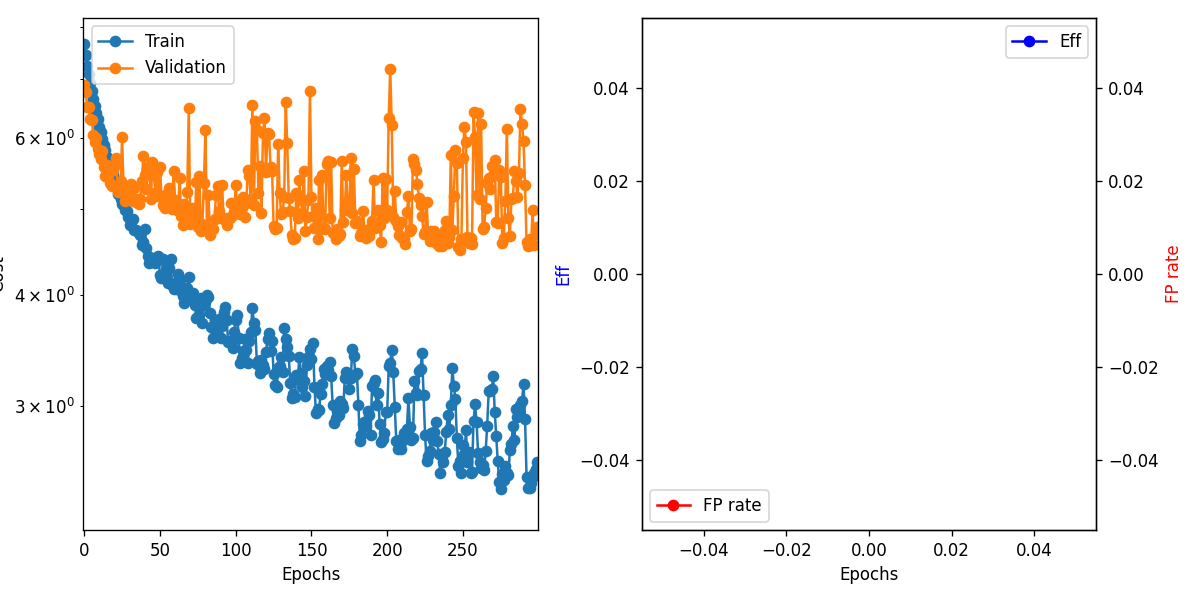

In [16]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [17]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 750, val = 834


Number of batches: train = 750, val = 834


Epoch 0: train=7.66612, val=6.88906, took 98.542 s


Epoch 1: train=7.44928, val=6.75771, took 98.352 s


Epoch 2: train=7.229, val=6.50732, took 98.138 s


Epoch 3: train=7.08028, val=6.51374, took 98.009 s


Epoch 4: train=6.92717, val=6.30618, took 97.858 s


Epoch 5: train=6.78699, val=6.28502, took 97.802 s


Epoch 6: train=6.64447, val=6.05234, took 97.964 s


Epoch 7: train=6.53064, val=5.9497, took 97.985 s


Epoch 8: train=6.41045, val=5.99958, took 97.839 s


Epoch 9: train=6.30295, val=5.83617, took 97.862 s


Epoch 10: train=6.17678, val=5.76834, took 97.783 s


Epoch 11: train=6.09917, val=5.68807, took 97.878 s


Epoch 12: train=5.98316, val=5.80028, took 97.704 s


Epoch 13: train=5.90141, val=5.56856, took 97.852 s


Epoch 14: train=5.81516, val=5.44387, took 97.767 s


Epoch 15: train=5.72286, val=5.60633, took 97.769 s


Epoch 16: train=5.64184, val=5.46291, took 97.822 s


Epoch 17: train=5.57585, val=5.34913, took 97.867 s


Epoch 18: train=5.54076, val=5.30487, took 97.832 s


Epoch 19: train=5.46282, val=5.52696, took 97.874 s


Epoch 20: train=5.39354, val=5.59671, took 97.674 s


Epoch 21: train=5.37028, val=5.69766, took 97.698 s


Epoch 22: train=5.19706, val=5.22857, took 97.868 s


Epoch 23: train=5.25477, val=5.26671, took 98.079 s


Epoch 24: train=5.13091, val=5.37466, took 98.158 s


Epoch 25: train=5.05631, val=6.02467, took 97.689 s


Epoch 26: train=5.13755, val=5.20805, took 97.744 s


Epoch 27: train=4.98536, val=5.10111, took 97.709 s


Epoch 28: train=4.97165, val=5.15745, took 97.78 s


Epoch 29: train=4.89611, val=5.16128, took 98.066 s


Epoch 30: train=4.79195, val=5.30925, took 97.963 s


Epoch 31: train=4.8357, val=5.32532, took 97.702 s


Epoch 32: train=4.86825, val=5.10358, took 97.649 s


Epoch 33: train=4.72717, val=5.27219, took 97.961 s


Epoch 34: train=4.73705, val=5.09468, took 98.415 s


Epoch 35: train=4.72408, val=5.13173, took 97.76 s


Epoch 36: train=4.70155, val=5.05862, took 97.642 s


Epoch 37: train=4.67645, val=5.12325, took 97.719 s


Epoch 38: train=4.55656, val=5.3731, took 97.656 s


Epoch 39: train=4.58312, val=5.7314, took 97.558 s


Epoch 40: train=4.74978, val=5.45416, took 97.072 s


Epoch 41: train=4.52308, val=5.26143, took 97.915 s


Epoch 42: train=4.42927, val=5.53607, took 97.551 s


Epoch 43: train=4.34832, val=5.59095, took 97.212 s


Epoch 44: train=4.40244, val=5.13381, took 97.528 s


Epoch 45: train=4.369, val=5.6375, took 97.423 s


Epoch 46: train=4.39838, val=5.4582, took 97.44 s


Epoch 47: train=4.34234, val=5.20443, took 97.741 s


Epoch 48: train=4.38802, val=5.49317, took 97.555 s


Epoch 49: train=4.42505, val=5.16531, took 97.565 s


Epoch 50: train=4.20839, val=5.57133, took 97.017 s


Epoch 51: train=4.1851, val=5.16345, took 96.98 s


Epoch 52: train=4.38523, val=5.04464, took 97.4 s


Epoch 53: train=4.2048, val=5.00435, took 97.759 s


Epoch 54: train=4.20322, val=5.13762, took 98.021 s


Epoch 55: train=4.12858, val=5.21721, took 97.912 s


Epoch 56: train=4.29335, val=5.28209, took 97.602 s


Epoch 57: train=4.38597, val=5.05933, took 97.702 s


Epoch 58: train=4.10401, val=5.00047, took 97.608 s


Epoch 59: train=4.06637, val=5.51137, took 97.635 s


Epoch 60: train=4.12461, val=5.11442, took 97.546 s


Epoch 61: train=4.06687, val=4.98128, took 97.685 s


Epoch 62: train=4.2221, val=5.01748, took 97.891 s


Epoch 63: train=4.15428, val=5.41443, took 97.533 s


Epoch 64: train=4.04311, val=4.90309, took 97.6 s


Epoch 65: train=3.98462, val=4.79968, took 97.56 s


Epoch 66: train=3.91658, val=5.05697, took 97.697 s


Epoch 67: train=4.01981, val=4.93482, took 97.715 s


Epoch 68: train=4.07264, val=5.22713, took 97.609 s


Epoch 69: train=4.19123, val=6.48718, took 97.548 s


Epoch 70: train=3.99302, val=4.80859, took 97.586 s


Epoch 71: train=3.96989, val=5.01444, took 97.587 s


Epoch 72: train=4.02447, val=4.96476, took 97.592 s


Epoch 73: train=3.90284, val=4.85447, took 97.619 s


Epoch 74: train=3.7663, val=5.35918, took 97.38 s


Epoch 75: train=3.92376, val=4.76509, took 97.055 s


Epoch 76: train=3.7988, val=5.43719, took 97.189 s


Epoch 77: train=3.96851, val=4.72395, took 97.414 s


Epoch 78: train=3.71938, val=4.80796, took 97.128 s


Epoch 79: train=3.89601, val=5.34735, took 97.128 s


Epoch 80: train=3.9322, val=6.12573, took 97.062 s


Epoch 81: train=3.99848, val=4.76833, took 97.565 s


Epoch 82: train=3.98048, val=5.18504, took 97.807 s


Epoch 83: train=3.81665, val=4.67329, took 97.516 s


Epoch 84: train=3.68537, val=4.74767, took 97.517 s


Epoch 85: train=3.57652, val=4.74587, took 97.658 s


Epoch 86: train=3.65833, val=4.86907, took 97.477 s


Epoch 87: train=3.73366, val=5.1867, took 97.579 s


Epoch 88: train=3.60307, val=5.30575, took 97.576 s


Epoch 89: train=3.76212, val=4.97017, took 97.837 s


Epoch 90: train=3.57728, val=4.8772, took 97.706 s


Epoch 91: train=3.69322, val=5.32434, took 98.71 s


Epoch 92: train=3.83032, val=4.87954, took 98.219 s


Epoch 93: train=3.8761, val=4.85267, took 97.636 s


Epoch 94: train=3.74786, val=4.78947, took 97.518 s


Epoch 95: train=3.54582, val=4.88269, took 97.547 s


Epoch 96: train=3.55364, val=4.88058, took 97.564 s


Epoch 97: train=3.53306, val=5.07715, took 97.568 s


Epoch 98: train=3.48785, val=4.9159, took 97.632 s


Epoch 99: train=3.6351, val=4.96276, took 97.9 s


Epoch 100: train=3.75154, val=5.31298, took 97.728 s


Epoch 101: train=3.79719, val=5.00415, took 97.716 s


Epoch 102: train=3.57801, val=5.0834, took 97.366 s


Epoch 103: train=3.35487, val=4.93783, took 97.152 s


Epoch 104: train=3.40212, val=5.01043, took 97.656 s


Epoch 105: train=3.45858, val=5.15008, took 97.592 s


Epoch 106: train=3.5678, val=4.89645, took 97.513 s


Epoch 107: train=3.47212, val=5.07794, took 97.73 s


Epoch 108: train=3.35428, val=5.53371, took 97.856 s


Epoch 109: train=3.54847, val=5.44249, took 97.625 s


Epoch 110: train=3.63277, val=5.12544, took 97.667 s


Epoch 111: train=3.87059, val=6.54447, took 98.48 s


Epoch 112: train=3.71813, val=5.05549, took 98.923 s


Epoch 113: train=3.65228, val=6.28235, took 98.929 s


Epoch 114: train=3.34635, val=6.13257, took 98.923 s


Epoch 115: train=3.36836, val=5.21075, took 98.917 s


Epoch 116: train=3.26659, val=5.59058, took 98.923 s


Epoch 117: train=3.38376, val=4.94248, took 98.292 s


Epoch 118: train=3.34029, val=6.07848, took 97.651 s


Epoch 119: train=3.30389, val=6.3213, took 97.486 s


Epoch 120: train=3.45385, val=5.50572, took 97.501 s


Epoch 121: train=3.57004, val=6.07807, took 97.543 s


Epoch 122: train=3.62287, val=6.06904, took 97.579 s


Epoch 123: train=3.45975, val=5.57388, took 97.447 s


Epoch 124: train=3.55407, val=5.51973, took 97.386 s


Epoch 125: train=3.26438, val=4.78645, took 97.523 s


Epoch 126: train=3.16773, val=4.74081, took 97.475 s


Epoch 127: train=3.15062, val=4.75307, took 97.602 s


Epoch 128: train=3.3111, val=5.91098, took 97.563 s


Epoch 129: train=3.32609, val=5.20663, took 97.482 s


Epoch 130: train=3.40367, val=4.92911, took 97.525 s


Epoch 131: train=3.27774, val=4.95888, took 98.358 s


Epoch 132: train=3.67673, val=5.15078, took 98.166 s


Epoch 133: train=3.57316, val=6.60045, took 97.416 s


Epoch 134: train=3.50004, val=5.9352, took 97.512 s


Epoch 135: train=3.42018, val=5.13535, took 97.625 s


Epoch 136: train=3.18201, val=4.96909, took 97.492 s


Epoch 137: train=3.06397, val=4.6698, took 97.652 s


Epoch 138: train=3.09618, val=4.6185, took 97.591 s


Epoch 139: train=3.0698, val=4.6366, took 98.684 s


Epoch 140: train=3.25402, val=5.20908, took 98.068 s


Epoch 141: train=3.22129, val=4.87729, took 97.719 s


Epoch 142: train=3.40598, val=5.38274, took 97.406 s


Epoch 143: train=3.26717, val=5.11064, took 97.392 s


Epoch 144: train=3.15557, val=4.95061, took 97.503 s


Epoch 145: train=3.20023, val=5.51335, took 97.479 s


Epoch 146: train=3.08023, val=4.71947, took 97.544 s


Epoch 147: train=3.33994, val=4.90069, took 97.484 s


Epoch 148: train=3.40925, val=5.11587, took 97.556 s


Epoch 149: train=3.47487, val=6.78263, took 97.546 s


Epoch 150: train=3.38732, val=5.15775, took 97.689 s


Epoch 151: train=3.53508, val=4.91239, took 97.599 s


Epoch 152: train=3.15081, val=4.75577, took 97.853 s


Epoch 153: train=2.94853, val=5.0098, took 97.676 s


Epoch 154: train=2.97688, val=4.62429, took 97.571 s


Epoch 155: train=2.96948, val=5.39386, took 97.558 s


Epoch 156: train=3.09407, val=4.74986, took 97.594 s


Epoch 157: train=3.17346, val=5.46045, took 97.606 s


Epoch 158: train=3.30103, val=4.75866, took 97.501 s


Epoch 159: train=3.26269, val=4.74087, took 97.767 s


Epoch 160: train=3.33134, val=5.61561, took 97.476 s


Epoch 161: train=3.29519, val=5.66444, took 97.35 s


Epoch 162: train=3.36234, val=4.88486, took 97.344 s


Epoch 163: train=3.24267, val=5.63855, took 97.527 s


Epoch 164: train=3.00813, val=4.69064, took 97.648 s


Epoch 165: train=2.87442, val=4.70513, took 97.067 s


Epoch 166: train=2.91277, val=4.62825, took 97.575 s


Epoch 167: train=2.96224, val=4.7439, took 97.825 s


Epoch 168: train=2.93266, val=4.66588, took 97.616 s


Epoch 169: train=3.03942, val=4.6794, took 97.629 s


Epoch 170: train=3.01363, val=5.6644, took 98.052 s


Epoch 171: train=2.98813, val=4.8321, took 97.534 s


Epoch 172: train=3.22557, val=4.98374, took 97.64 s


Epoch 173: train=3.27845, val=5.45155, took 98.267 s


Epoch 174: train=3.25951, val=4.98355, took 98.13 s


Epoch 175: train=3.13871, val=4.99211, took 97.636 s


Epoch 176: train=3.22532, val=5.70624, took 97.504 s


Epoch 177: train=3.48107, val=4.95168, took 97.488 s


Epoch 178: train=3.41441, val=5.54309, took 97.514 s


Epoch 179: train=3.25582, val=4.82133, took 97.639 s


Epoch 180: train=3.26885, val=4.84258, took 97.547 s


Epoch 181: train=3.00619, val=4.82094, took 97.491 s


Epoch 182: train=2.74247, val=4.6568, took 97.636 s


Epoch 183: train=2.78608, val=4.69563, took 97.68 s


Epoch 184: train=2.86653, val=4.97166, took 97.919 s


Epoch 185: train=2.87971, val=4.73712, took 97.829 s


Epoch 186: train=2.85138, val=4.63391, took 97.494 s


Epoch 187: train=2.9638, val=4.67931, took 97.63 s


Epoch 188: train=2.93403, val=4.66405, took 97.526 s


Epoch 189: train=2.78118, val=4.77472, took 97.614 s


Epoch 190: train=3.16186, val=4.84977, took 97.674 s


Epoch 191: train=3.18154, val=5.39126, took 97.475 s


Epoch 192: train=3.21356, val=4.75717, took 97.586 s


Epoch 193: train=3.00509, val=4.77564, took 97.494 s


Epoch 194: train=3.10027, val=4.99042, took 97.439 s


Epoch 195: train=2.8667, val=4.7923, took 97.662 s


Epoch 196: train=2.73338, val=4.59104, took 97.772 s


Epoch 197: train=2.75552, val=5.41018, took 97.471 s


Epoch 198: train=2.79671, val=4.88068, took 97.58 s


Epoch 199: train=2.95214, val=5.40296, took 98.319 s


Epoch 200: train=2.95361, val=4.98223, took 97.948 s


Epoch 201: train=3.33031, val=6.32607, took 97.519 s


Epoch 202: train=3.35777, val=7.18327, took 97.462 s


Epoch 203: train=3.47338, val=6.21766, took 97.538 s


Epoch 204: train=3.27341, val=4.89695, took 97.455 s


Epoch 205: train=2.99412, val=5.23996, took 97.685 s


Epoch 206: train=2.73996, val=4.84347, took 97.69 s


Epoch 207: train=2.68202, val=4.78186, took 97.597 s


Epoch 208: train=2.74609, val=4.66663, took 97.531 s


Epoch 209: train=2.68682, val=4.8281, took 97.54 s


Epoch 210: train=2.74204, val=4.63474, took 97.849 s


Epoch 211: train=2.79764, val=4.62396, took 97.637 s


Epoch 212: train=2.76619, val=4.56166, took 97.934 s


Epoch 213: train=2.82686, val=4.96495, took 97.781 s


Epoch 214: train=3.06348, val=5.16312, took 97.367 s


Epoch 215: train=2.8448, val=4.72548, took 97.426 s


Epoch 216: train=2.74563, val=4.74662, took 97.609 s


Epoch 217: train=2.7589, val=5.69337, took 97.439 s


Epoch 218: train=3.20038, val=5.61683, took 97.731 s


Epoch 219: train=3.10498, val=5.53488, took 97.349 s


Epoch 220: train=3.08667, val=5.33022, took 97.401 s


Epoch 221: train=3.28282, val=5.1359, took 97.345 s


Epoch 222: train=3.30306, val=5.0501, took 97.469 s


Epoch 223: train=3.44167, val=4.90787, took 97.338 s


Epoch 224: train=3.08984, val=4.68337, took 97.269 s


Epoch 225: train=2.78257, val=4.70706, took 97.362 s


Epoch 226: train=2.60592, val=5.08894, took 97.416 s


Epoch 227: train=2.63436, val=4.67463, took 97.466 s


Epoch 228: train=2.66847, val=4.59807, took 97.459 s


Epoch 229: train=2.79518, val=4.72556, took 97.539 s


Epoch 230: train=2.74702, val=4.68408, took 97.573 s


Epoch 231: train=2.80519, val=4.72049, took 97.534 s


Epoch 232: train=2.88292, val=4.57391, took 97.321 s


Epoch 233: train=2.74424, val=4.6673, took 97.365 s


Epoch 234: train=2.64987, val=4.54652, took 97.259 s


Epoch 235: train=2.52161, val=4.66462, took 97.342 s


Epoch 236: train=2.63644, val=4.54459, took 97.441 s


Epoch 237: train=2.59856, val=4.64457, took 97.454 s


Epoch 238: train=2.667, val=4.73735, took 97.677 s


Epoch 239: train=2.80813, val=4.83979, took 97.608 s


Epoch 240: train=2.93055, val=4.57618, took 97.514 s


Epoch 241: train=2.82836, val=4.6512, took 97.63 s


Epoch 242: train=3.00557, val=5.74245, took 97.447 s


Epoch 243: train=3.3133, val=4.73874, took 97.449 s


Epoch 244: train=3.16405, val=5.16661, took 97.454 s


Epoch 245: train=3.05585, val=5.82759, took 97.896 s


Epoch 246: train=2.76095, val=5.62564, took 97.747 s


Epoch 247: train=2.57114, val=4.53252, took 97.303 s


Epoch 248: train=2.5996, val=4.49651, took 97.323 s


Epoch 249: train=2.52584, val=4.62182, took 97.505 s


Epoch 250: train=2.71176, val=5.70599, took 97.636 s


Epoch 251: train=2.64711, val=6.18436, took 97.645 s


Epoch 252: train=2.81839, val=5.94257, took 97.729 s


Epoch 253: train=2.59346, val=4.65366, took 97.715 s


Epoch 254: train=2.66601, val=4.57696, took 97.813 s


Epoch 255: train=2.52396, val=4.6376, took 97.672 s


Epoch 256: train=2.53179, val=4.57005, took 97.656 s


Epoch 257: train=2.88701, val=6.42392, took 97.737 s


Epoch 258: train=3.01513, val=6.02018, took 97.596 s


Epoch 259: train=2.88037, val=5.18502, took 97.549 s


Epoch 260: train=2.65617, val=6.40293, took 97.347 s


Epoch 261: train=2.59388, val=5.12874, took 97.224 s


Epoch 262: train=2.55321, val=6.22749, took 97.342 s


Epoch 263: train=2.57385, val=4.74832, took 97.418 s


Epoch 264: train=2.54434, val=4.77308, took 97.452 s


Epoch 265: train=2.66799, val=5.01152, took 98.088 s


Epoch 266: train=2.85091, val=5.34395, took 97.614 s


Epoch 267: train=3.11711, val=5.40969, took 97.499 s


Epoch 268: train=3.12328, val=5.26925, took 97.477 s


Epoch 269: train=3.13305, val=5.58398, took 97.475 s


Epoch 270: train=3.23928, val=5.45232, took 97.464 s


Epoch 271: train=2.95599, val=5.67794, took 97.453 s


Epoch 272: train=2.77541, val=4.82836, took 97.383 s


Epoch 273: train=2.60024, val=4.82293, took 97.414 s


Epoch 274: train=2.46584, val=5.52321, took 97.461 s


Epoch 275: train=2.41847, val=5.42468, took 97.372 s


Epoch 276: train=2.51913, val=4.57945, took 97.38 s


Epoch 277: train=2.47999, val=4.63873, took 97.608 s


Epoch 278: train=2.56901, val=5.10849, took 98.519 s


Epoch 279: train=2.52631, val=6.15436, took 98.813 s


Epoch 280: train=2.5117, val=4.87913, took 98.086 s


Epoch 281: train=2.67832, val=4.65547, took 97.608 s


Epoch 282: train=2.72098, val=5.13025, took 97.848 s


Epoch 283: train=2.85098, val=5.14304, took 97.589 s


Epoch 284: train=2.75051, val=5.52014, took 97.38 s


Epoch 285: train=2.98078, val=5.36865, took 97.294 s


Epoch 286: train=2.9155, val=5.15909, took 97.272 s


Epoch 287: train=2.96174, val=5.48576, took 97.383 s


Epoch 288: train=3.00702, val=6.48097, took 97.271 s


Epoch 289: train=3.04001, val=6.23351, took 97.33 s


Epoch 290: train=3.17306, val=5.95264, took 97.427 s


Epoch 291: train=2.90355, val=5.32385, took 97.484 s


Epoch 292: train=2.50038, val=4.58297, took 97.328 s


Epoch 293: train=2.42906, val=4.53648, took 97.387 s


Epoch 294: train=2.42833, val=4.62691, took 97.461 s


Epoch 295: train=2.46021, val=4.54987, took 97.571 s


Epoch 296: train=2.49708, val=4.98599, took 97.543 s


Epoch 297: train=2.52479, val=4.55737, took 97.583 s


Epoch 298: train=2.54811, val=4.68817, took 97.526 s


Epoch 299: train=2.59592, val=4.77378, took 97.426 s



Go ahead and save the final model (even though it was also saved above):

In [18]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [19]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

Save the plot above:

<IPython.core.display.Javascript object>


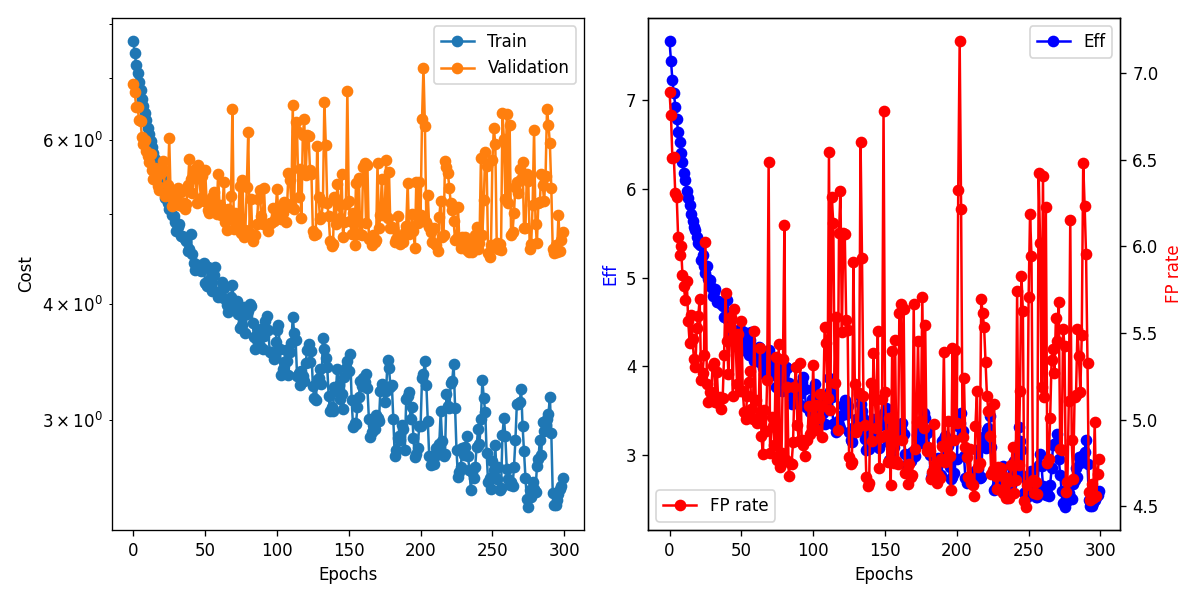

In [20]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [1]:
##quit()
